# RNNs Assignment
---

## Canada Cheese Production Forecasting

Using the [can_cheese.csv](../Data/can_cheese.csv) file, predict the expected cheese production for Canada from June 2024 to May 2025 (12 months).

The csv file contains cheese production in tonnes from January 2004 - May 2024.

Data obtained from [Statistics Canada](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3210011201).

## Q1: Imports and Data Reading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.trainers.data_adapters')

In [2]:
df = pd.read_csv('../Data/can_cheese.csv')

## Q2: EDA

Perform basic EDA.

In [3]:
# EDA

In [4]:
# Display the first few rows  
df.head()

,Month,Cheddar cheese,Speciality cheese,Cottage cheese 3,Pizza cheese 4,Mozzarella cheese,Colby cheese,Brick cheese,Havarti cheese,Provolone cheese,Emmental and swiss cheese,Cream cheese,Feta cheese,Gouda cheese,Monterey jack cheese,Parmesan cheese,Ricotta cheese,"Farmer's, skim cheese",Friulano and casata cheese
0,January 2004,"10,918","16,933","2,072",517,"9,021",76,620,440,182,640,"1,672",297,220,241,623,551,113,7
1,February 2004,"9,406","15,472","2,164",530,"8,217",165,303,284,185,501,"1,959",320,241,168,376,544,98,7
2,March 2004,"9,931","17,220","2,199",527,"8,754",30,407,372,164,714,"2,666",347,209,235,569,647,137,7
3,April 2004,"10,287","18,557","2,325",577,"9,583",29,301,477,157,622,"2,673",304,233,533,569,660,115,7
4,May 2004,"9,555","17,457","1,958",516,"9,280",27,359,358,154,620,"2,103",323,197,463,526,553,114,7


In [5]:
# Display general information about the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Month                       245 non-null    object
 1   Cheddar cheese              245 non-null    object
 2   Speciality cheese           245 non-null    object
 3   Cottage cheese 3            245 non-null    object
 4   Pizza cheese 4              245 non-null    object
 5   Mozzarella cheese           245 non-null    object
 6   Colby cheese                245 non-null    object
 7   Brick cheese                245 non-null    int64 
 8   Havarti cheese              245 non-null    int64 
 9   Provolone cheese            245 non-null    object
 10  Emmental and swiss cheese   245 non-null    object
 11  Cream cheese                245 non-null    object
 12  Feta cheese                 245 non-null    object
 13  Gouda cheese                245 non-null    object

In [6]:
# Checking for missing values
missing_values = df.isnull().sum()
missing_values

Month                         0
Cheddar cheese                0
Speciality cheese             0
Cottage cheese 3              0
Pizza cheese 4                0
Mozzarella cheese             0
Colby cheese                  0
Brick cheese                  0
Havarti cheese                0
Provolone cheese              0
Emmental and swiss cheese     0
Cream cheese                  0
Feta cheese                   0
Gouda cheese                  0
Monterey jack cheese          0
Parmesan cheese               0
Ricotta cheese                0
Farmer's, skim cheese         0
Friulano and casata cheese    0
dtype: int64

In [7]:
# Checking the data types of each column
data_types = df.dtypes
data_types

# Convert all other columns to numeric types, replacing 'x' with NaN and removing commas
for column in df.columns[1:]:
    df[column] = pd.to_numeric(df[column].astype(str).replace('x', np.nan).str.replace(',', ''), errors='coerce')

# Verify the conversions by checking the data types and looking at the first few rows
data_types_after_conversion = df.dtypes
df_head_after_conversion = df.head()

In [8]:
data_types_after_conversion

Month                          object
Cheddar cheese                  int64
Speciality cheese               int64
Cottage cheese 3                int64
Pizza cheese 4                float64
Mozzarella cheese               int64
Colby cheese                  float64
Brick cheese                    int64
Havarti cheese                  int64
Provolone cheese              float64
Emmental and swiss cheese     float64
Cream cheese                  float64
Feta cheese                   float64
Gouda cheese                  float64
Monterey jack cheese            int64
Parmesan cheese                 int64
Ricotta cheese                  int64
Farmer's, skim cheese         float64
Friulano and casata cheese    float64
dtype: object

In [9]:
df_head_after_conversion

,Month,Cheddar cheese,Speciality cheese,Cottage cheese 3,Pizza cheese 4,Mozzarella cheese,Colby cheese,Brick cheese,Havarti cheese,Provolone cheese,Emmental and swiss cheese,Cream cheese,Feta cheese,Gouda cheese,Monterey jack cheese,Parmesan cheese,Ricotta cheese,"Farmer's, skim cheese",Friulano and casata cheese
0,January 2004,10918,16933,2072,517.0,9021,76.0,620,440,182.0,640.0,1672.0,297.0,220.0,241,623,551,113.0,7.0
1,February 2004,9406,15472,2164,530.0,8217,165.0,303,284,185.0,501.0,1959.0,320.0,241.0,168,376,544,98.0,7.0
2,March 2004,9931,17220,2199,527.0,8754,30.0,407,372,164.0,714.0,2666.0,347.0,209.0,235,569,647,137.0,7.0
3,April 2004,10287,18557,2325,577.0,9583,29.0,301,477,157.0,622.0,2673.0,304.0,233.0,533,569,660,115.0,7.0
4,May 2004,9555,17457,1958,516.0,9280,27.0,359,358,154.0,620.0,2103.0,323.0,197.0,463,526,553,114.0,7.0


In [10]:
# Handle missing values using forward fill method 
df_filled = df.ffill().bfill()

# Verify that there are no more missing values
missing_values_after_filling = df_filled.isnull().sum()

missing_values_after_filling

Month                         0
Cheddar cheese                0
Speciality cheese             0
Cottage cheese 3              0
Pizza cheese 4                0
Mozzarella cheese             0
Colby cheese                  0
Brick cheese                  0
Havarti cheese                0
Provolone cheese              0
Emmental and swiss cheese     0
Cream cheese                  0
Feta cheese                   0
Gouda cheese                  0
Monterey jack cheese          0
Parmesan cheese               0
Ricotta cheese                0
Farmer's, skim cheese         0
Friulano and casata cheese    0
dtype: int64

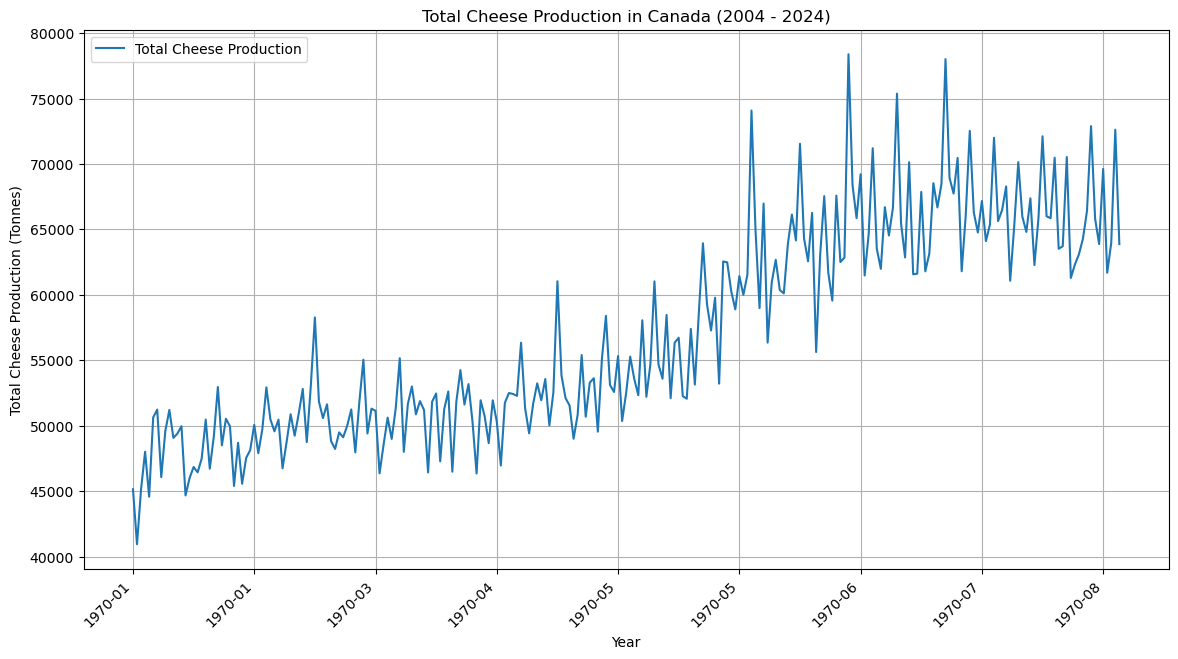

In [11]:
# First, we'll create a 'Total_cheese' column that sums up all cheese types for each month
cheese_columns = df_filled.columns[1:]  
df_filled['Total_cheese'] = df_filled[cheese_columns].sum(axis=1)

# Plotting the total cheese production over time
plt.figure(figsize=(14, 7))
plt.plot(df_filled['Month'], df_filled['Total_cheese'], label='Total Cheese Production')
plt.xlabel('Year')
plt.ylabel('Total Cheese Production (Tonnes)')
plt.title('Total Cheese Production in Canada (2004 - 2024)')
plt.legend()

# Improve x-axis formatting
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit the number of ticks to 10
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))  # Format dates as Year-Month
plt.grid(True)
plt.show()

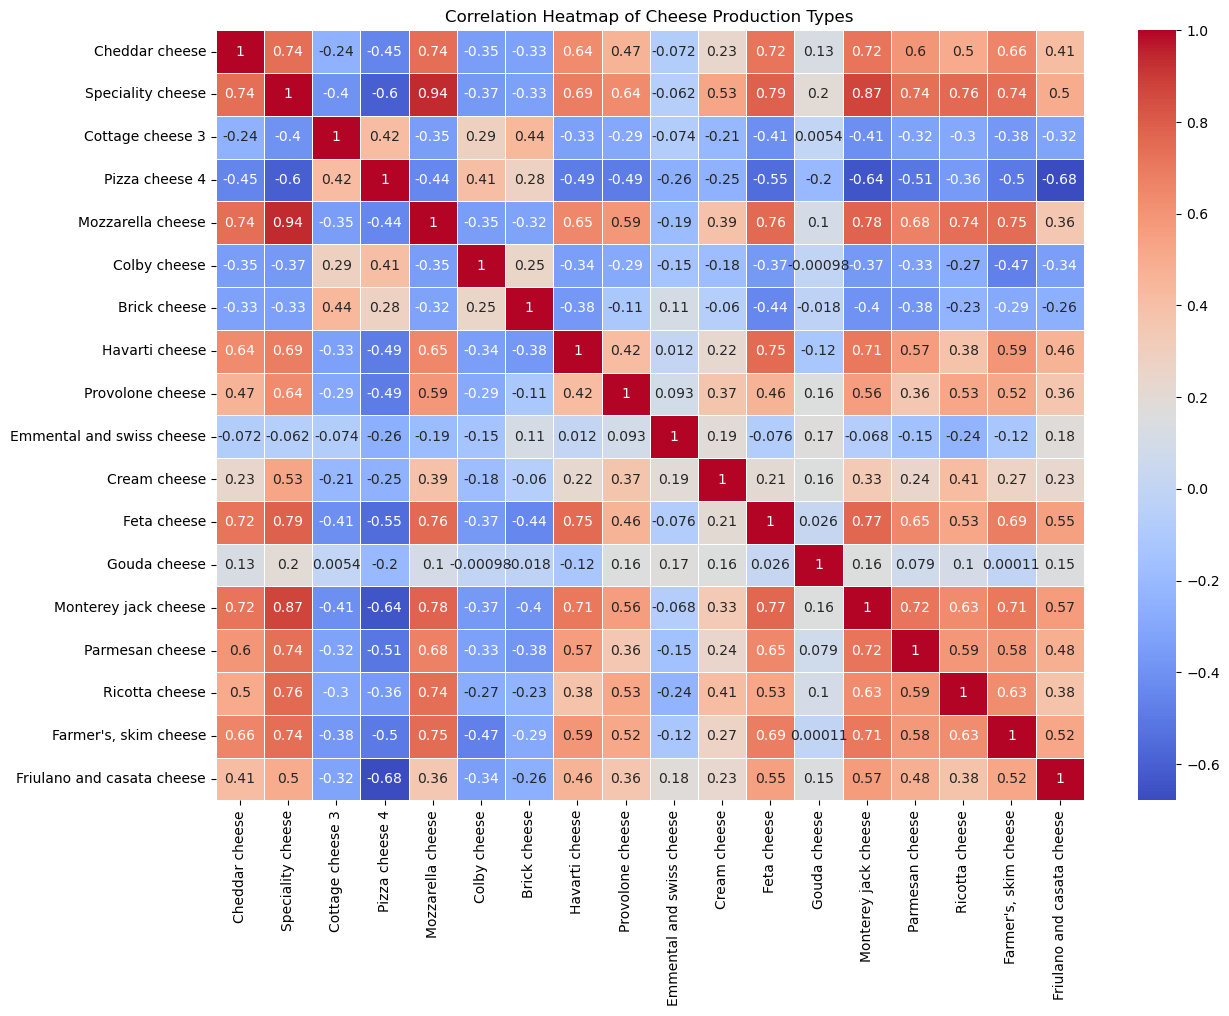

In [12]:
# Correlation Heatmap

# Calculating the correlation matrix
correlation_matrix = df_filled[cheese_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Cheese Production Types')
plt.show()

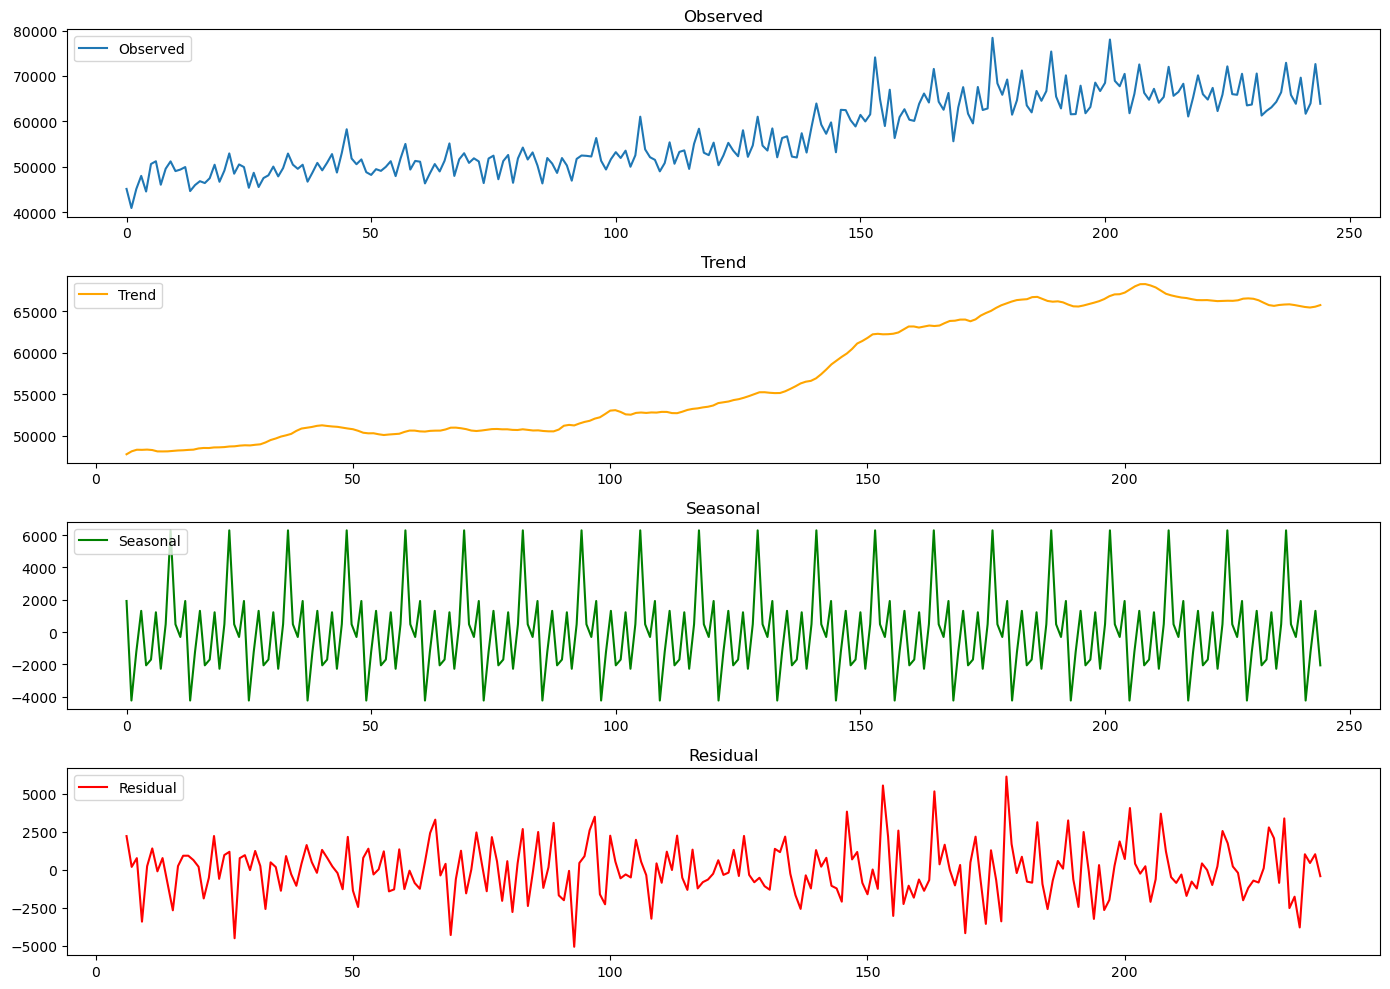

In [13]:
# To show seasonality, we'll decompose the time series data of total cheese production using seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(df_filled['Total_cheese'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.title('Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.title('Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Observed:The series appears to show an upward trend with some clear seasonal fluctuations.

Trend: Around the middle of the series, there is a noticeable increase in the trend.

Seasonal: Strong and regular seasonal effects on the data.

Residual: he residuals seem to fluctuate around zero without any obvious pattern

## Q3: Data Preprocessing

Note that some values are marked as "x" in the dataset.

- 3.1: Convert the "x" values into NaN values.
- 3.2: Create a `Total_cheese` colum that has the sum value of all the cheese types for each month.
- 3.3: Remove the individual cheese columns from the DataFrame.

The head of your DataFrame should look like this after completing 3.3:

<img src="../Data/cheese_df1.png" width="200">

- 3.4: Convert the `Month` column to yyyy-mm-dd format, and set it as the index of the DataFrame.

The head of your DataFrame should look like this after completing 3.4:

<img src="../Data/cheese_df2.png" width="200">

Notice the position of the Month `column`, indicating that it has been set as the index.

- 3.5: Split the data into training and testing sets. Set the test set to the last 24 months of the data.
- 3.6: Perform data scaling

In [14]:
# 3.1
df.replace("x", np.nan, inplace=True)

In [15]:
# 3.2
# Sum the cheese production across all columns
cheese_columns = df.columns[1:]
df['Total_cheese'] = df[cheese_columns].sum(axis=1, skipna=True)

In [16]:
# 3.3
# Prepare the final dataframe
df_final = df[['Month', 'Total_cheese']].copy()
df_final.head()

,Month,Total_cheese
0,January 2004,45143.0
1,February 2004,40940.0
2,March 2004,45135.0
3,April 2004,48009.0
4,May 2004,44570.0


In [17]:
# 3.4
# Convert the 'Month' column to datetime format
df_final['Month'] = pd.to_datetime(df_final['Month'], format='%B %Y')

# Format the datetime to 'YYYY-MM-DD' and set it as the index
df_final['Month'] = df_final['Month'].dt.strftime('%Y-%m-%d')
df_final.set_index('Month', inplace=True)

# Display the first few rows to verify the changes
df_final[['Total_cheese']].head()

,Total_cheese
Month,
2004-01-01,45143.0
2004-02-01,40940.0
2004-03-01,45135.0
2004-04-01,48009.0
2004-05-01,44570.0


In [18]:
# 3.5
# Split the data into training and testing sets
train_set = df_final[:-24]
test_set = df_final[-24:]

In [19]:
# 3.6
# Scale the data using StandardScaler
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train_set), index=train_set.index, columns=train_set.columns)

## Q4: Timeseries Generator

Create a `TimeseriesGenerator` object based off the scaled training data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.

In [20]:
# 4
# Increase the sequence length for the TimeseriesGenerator
sequence_length = 36  # Increased to capture more historical data

# Define the features (X) and target (y) for the TimeseriesGenerator
features = train_scaled.values
target = train_scaled['Total_cheese'].values

# Set up the TimeseriesGenerator for the training data
train_generator = TimeseriesGenerator(features, target, length=sequence_length, batch_size=1)

## Q5: Build and Compile Model

- 5.1 Create a Sequential Keras model. Choose a reasonable number of LSTM units.
- 5.2: Print the summary of your model.

In [21]:
# 5.1
# Build a more complex RNN model with stacked LSTM/GRU layers
model = Sequential()
model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(sequence_length, features.shape[1])))
model.add(Dropout(0.4))
model.add(LSTM(units=100, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(GRU(units=100, activation='relu'))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')
# Step 5.2: Print the summary of the model
model.summary()

C:\Users\info\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 36, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 36, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,901 (710.55 KB)

 Trainable params: 181,901 (710.55 KB)

 Non-trainable params: 0 (0.00 B)

## Q6: Model Training

Fit a RNN model to the generator. Use EarlyStopping to dictate the number of epochs.

In [22]:
# 6
# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model for more epochs with the new callbacks
history = model.fit(train_generator, epochs=200, validation_data=train_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.6773 - val_loss: 0.3196 - learning_rate: 0.0010
Epoch 2/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.2637 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 3/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.2897 - val_loss: 0.2603 - learning_rate: 0.0010
Epoch 4/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.2620 - val_loss: 0.2455 - learning_rate: 0.0010
Epoch 5/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.2862 - val_loss: 0.2695 - learning_rate: 0.0010
Epoch 6/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.2419 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 7/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.2933 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 8/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.2617 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 9/200
185/185 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.3595 - val_loss: 0.2699 - learning_rate

## Q7: Model Evaluation

- 7.1: Obtain the predictions for the test data range (24 months)
- 7.2: Inverse the scaling transformation to compare the original test values with the predictions. Your results here should be DataFrame with 2 columns, the true test values and the predictions. 

The head of your DataFrame should look like this:

<img src="../Data/comparison_df.png" width="300">

Note that your predicted values might be different from the values displayed here.

- 7.3: Obtain the RMSE for the test data. Briefly explain your RMSE. Is it "good"?
- 7.4: Plot your predictions vs. the true test values.

In [23]:
# 7.1
# Forecasting the next 24 months based on the training data
# Start by taking the last sequence from the training data
last_train_sequence = train_scaled[-sequence_length:].values
last_train_sequence = last_train_sequence.reshape((1, sequence_length, features.shape[1]))

# Generate 24 months of predictions
predictions_scaled = []
for i in range(24):
    pred = model.predict(last_train_sequence)
    predictions_scaled.append(pred[0, 0])  # Extract the scalar prediction value
    # Update the last_train_sequence to include the new prediction
    new_sequence = np.append(last_train_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    last_train_sequence = new_sequence

# Convert predictions back to original scale
predictions_scaled = np.array(predictions_scaled)
predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [24]:
# 7.2
# Use the original test set for comparison (not scaled)
actual_values = test_set['Total_cheese'].values.reshape(-1, 1)

# Create a DataFrame to compare the predictions with actual values
pred_df = pd.DataFrame({
    'Total_cheese': actual_values.flatten(),
    'Prnn_preds': predictions.flatten()
}, index=test_set.index)

# Display the comparison
pred_df.head()

,Total_cheese,Prnn_preds
Month,,
2022-06-01,60195.0,61352.546875
2022-07-01,66352.0,65945.390625
2022-08-01,61155.0,64861.328125
2022-09-01,65752.0,65463.011719
2022-10-01,68179.0,69580.578125


In [25]:
# 7.3
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(pred_df['Total_cheese'], pred_df['Prnn_preds']))
print(f"RMSE: {rmse}")

RMSE: 1831.2496373626038


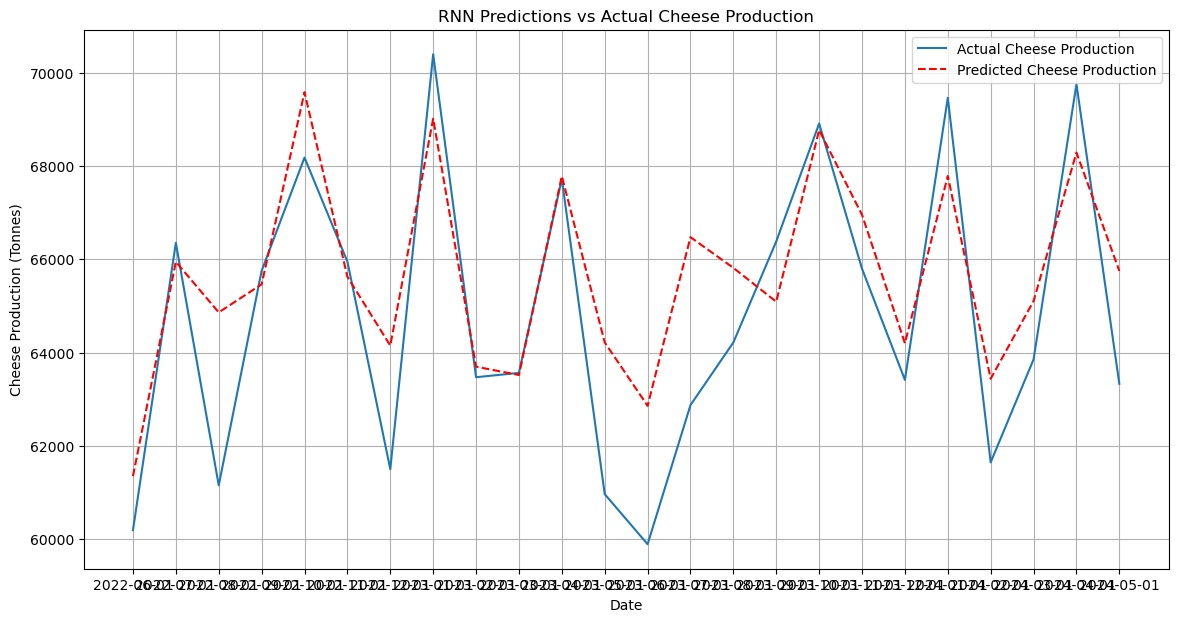

In [26]:
# 7.4
# Plot the predictions against actual values
plt.figure(figsize=(14, 7))
plt.plot(pred_df.index, pred_df['Total_cheese'], label="Actual Cheese Production")
plt.plot(pred_df.index, pred_df['Prnn_preds'], label="Predicted Cheese Production", linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Cheese Production (Tonnes)')
plt.title('RNN Predictions vs Actual Cheese Production')
plt.legend()
plt.grid(True)
plt.show()

## Q8: BONUS: Forecast Next 12 Months

- 8.1: Generate cheese predictions starting June 2024 until May 2025.
- 8.2: Plot the predictions

In [27]:
# 8.1
# Start by taking the last sequence from the training data
last_train_sequence = train_scaled[-sequence_length:].values
last_train_sequence = last_train_sequence.reshape((1, sequence_length, features.shape[1]))

# Generate 24 months of predictions (based on the test set period)
predictions_scaled = []
for i in range(24):
    pred = model.predict(last_train_sequence)
    predictions_scaled.append(pred[0, 0])  # Extract the scalar prediction value
    # Update the last_train_sequence to include the new prediction
    new_sequence = np.append(last_train_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    last_train_sequence = new_sequence

# Continue generating predictions for the next 12 months (June 2024 to May 2025)
next_12_months_predictions_scaled = []
for i in range(12):
    pred = model.predict(last_train_sequence)
    next_12_months_predictions_scaled.append(pred[0, 0])  # Extract the scalar prediction value
    # Update the last_train_sequence to include the new prediction
    new_sequence = np.append(last_train_sequence[:, 1:, :], [[[pred[0, 0]]]], axis=1)
    last_train_sequence = new_sequence

# Convert all predictions back to original scale
next_12_months_predictions_scaled = np.array(next_12_months_predictions_scaled)
next_12_months_predictions = scaler.inverse_transform(next_12_months_predictions_scaled.reshape(-1, 1))

# Create a date range for the next 12 months
forecast_dates = pd.date_range(start="2024-06-01", periods=12, freq='MS')

# Create a DataFrame to hold the forecasted values
forecast_df = pd.DataFrame({
    'Forecast_Cheese_Production': next_12_months_predictions.flatten()
}, index=forecast_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

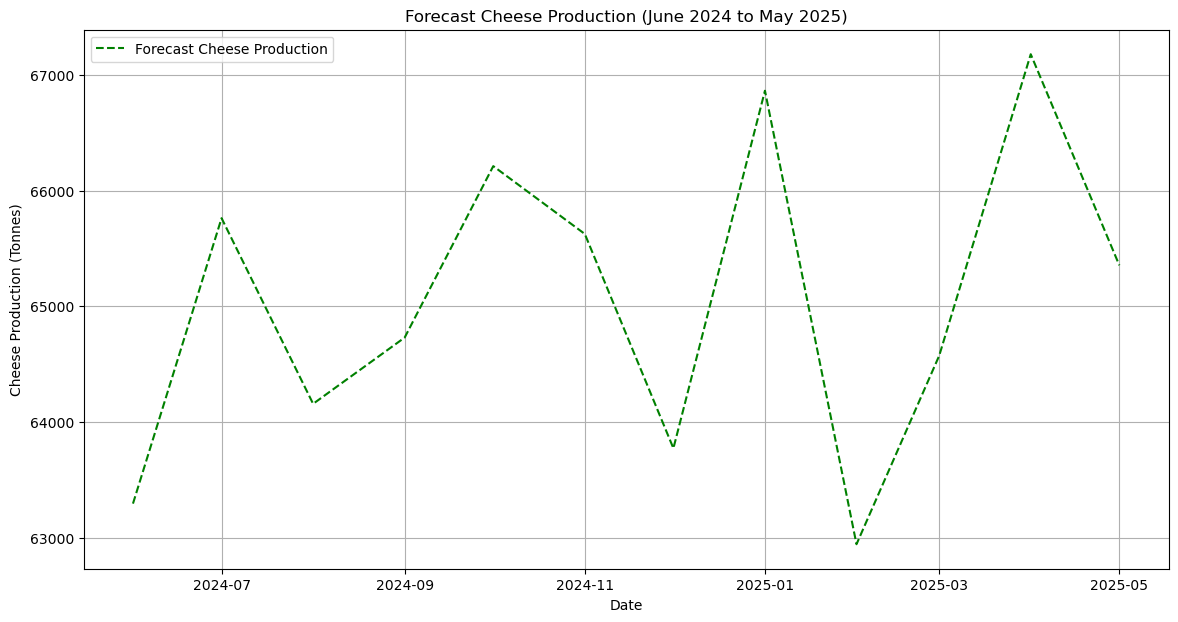

In [28]:
# 8.2
# Plot the forecasted predictions
plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Forecast_Cheese_Production'], label="Forecast Cheese Production", linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Cheese Production (Tonnes)')
plt.title('Forecast Cheese Production (June 2024 to May 2025)')
plt.legend()
plt.grid(True)
plt.show()

## Great Job!